Import Libraries

In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import gaussian, threshold_otsu, threshold_multiotsu, sobel
from skimage.morphology import remove_small_objects, disk, binary_closing
from scipy.ndimage import zoom, binary_dilation, binary_erosion
from skimage.measure import label, regionprops
from skimage import io, exposure, color
from skimage import measure, morphology
from skimage import exposure
from czifile import imread
from cellpose import models, plot 
import cv2
import re

Define Sub Functions

In [20]:
def display_image(image, path, type):
    """Display the image."""
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{path} {type}")
    plt.show()

def z_stack_display_image(image, path, type, z_stack):
    """Display the image."""
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{path} {type} zstack: {z_stack}")
    plt.show()

def extract_image_paths(folder):
    """Extract all image file paths from the specified folder."""
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

def read_image(image_path):
    """Read the LSM image from the specified path."""
    return imread(image_path)

def extract_channels(image: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Extract green and red channels from the squeezed image (shape: [Z, C, H, W]).""" 
    return image[0], image[1]
    
def green_binary_maker(image: np.ndarray, image_path: str, value: int) -> np.ndarray:
    if (re.search(r'FCCP', image_path)):
        return image > 35000
    
    return image > value

def red_binary_maker(image: np.ndarray, image_path: str, value: int) -> np.ndarray:
    if (re.search(r'FCCP', image_path)):
        return image > 7000
    threshold = threshold_otsu(image)

    return image > threshold

def clean_MIP_image(width: int, height: int, green: np.ndarray, red: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    square_size = 30
    color_detected = False
    while (color_detected == False):
        top_right_square = green[0:square_size, width-square_size:width]
        binary_image = top_right_square > threshold_otsu(top_right_square)
        has_objects = np.any(binary_image)
        if has_objects:
            color_detected = True
        else:
            square_size += 2
    green_cleaned = green[square_size:height, 0:width-square_size] #getting the green and red channel without the rows
    red_cleaned = red[square_size:height, 0:width-square_size]

    return green_cleaned, red_cleaned

def calculate_surface_area(labeled_image: np.ndarray) -> float:
    """Calculate the total surface area for labeled regions."""
    props = regionprops(labeled_image)
    return sum(prop.area for prop in props)

def find_overlap(mask1: np.ndarray, mask2: np.ndarray) -> np.ndarray:
    """Combine two binary masks."""
    combined_mask = np.logical_and(mask1, mask2)
    return combined_mask.astype(np.uint8)

def MIP_analysis(green: np.ndarray, red: np.ndarray, width: int, height: int, path:str) -> pd.DataFrame:
    data = []


    green_cleaned, red_cleaned = clean_MIP_image(width, height, green, red)
    green_binary = green_binary_maker(green_cleaned, path, 37000)
    red_binary = red_binary_maker(red_cleaned, path, 10000)
    overlap_mask = find_overlap(green_binary, red_binary)

    #display_image(green_binary, path, "Green Binary")
    #display_image(red_binary, path, "Red Binary")
    #display_image(overlap_mask, path, "Overlap Mask")

    labeled_green = label(green_binary)
    labeled_red = label(red_binary)

    green_surface_area = calculate_surface_area(labeled_green)
    red_surface_area = calculate_surface_area(labeled_red)
    overlap_surface_area = calculate_surface_area(overlap_mask)


    data.append({
        'Filename': path,
        'Green Surface Area': green_surface_area,
        'Red Surface Area': red_surface_area,
        'Overlap Surface Area': overlap_surface_area,
        'Overlap / Green Surface Area': overlap_surface_area / green_surface_area if green_surface_area > 0 else 0,
        'Overlap / Red Surface Area': overlap_surface_area / red_surface_area if red_surface_area > 0 else 0,
    })

    df_cell_summary = pd.DataFrame(data)

    return df_cell_summary

def remove_small_objects_only(binary_image, min_size=100):
    labeled_image = measure.label(binary_image)

    # Remove objects smaller than min_size
    filtered_image = morphology.remove_small_objects(labeled_image, min_size=min_size)

    # Convert back to binary mask
    return filtered_image > 0

def z_stack(image_squeezed: np.ndarray, image_path: str) -> pd.DataFrame:
    """Process the Z-stack image and return a DataFrame with surface area data."""
    # Extract the dimensions of the image
    c, z, height, width = image_squeezed.shape
    data = []
    data_total = []
    # Initialize an empty DataFrame to store results
    df_cell_summary = pd.DataFrame()
    df_cell_summary_total = pd.DataFrame()

    total_image_green = np.zeros((height, width), dtype=np.float32)
    total_image_red = np.zeros((height, width), dtype=np.float32)

    # Process each Z-slice
    for i in range(z):


        green = image_squeezed[0, i, :, :]  # Green channel, Z-slice i
        red = image_squeezed[1, i, :, :]    # Red channel, Z-slice i


        if (re.search(r'FCCP', image_path)):
            contrast_adjusted_red = exposure.adjust_sigmoid(red, cutoff=0.25) 
            contrast_adjusted_red_normalized = (contrast_adjusted_red - contrast_adjusted_red.min()) / (contrast_adjusted_red.max() - contrast_adjusted_red.min())
            threshold_value_mitochondria = np.mean(contrast_adjusted_red_normalized) + (np.std(contrast_adjusted_red_normalized) * 2) #1.75 works well
            mitochondria_thresholded = contrast_adjusted_red_normalized > threshold_value_mitochondria

            mitochondria_thresholded = remove_small_objects_only(mitochondria_thresholded, min_size=20)
        else:
            contrast_adjusted_red_normalized = (red - red.min()) / (red.max() - red.min())
            threshold_value_mitochondria = np.mean(contrast_adjusted_red_normalized) + (np.std(contrast_adjusted_red_normalized) * 2) #1.75 works well
            mitochondria_thresholded = contrast_adjusted_red_normalized > threshold_value_mitochondria

        #z_stack_display_image(mitochondria_thresholded, image_path, "Red", i + 1)
        
        constrast_adjusted_green_normalized = (green - green.min()) / (green.max() - green.min())
        threshold_value_green = np.mean(constrast_adjusted_green_normalized) + (np.std(constrast_adjusted_green_normalized) * 3.25) #1.75 works well
        green_thresholded = constrast_adjusted_green_normalized > threshold_value_green

        #print(i+1, "Green Threshold:", threshold_value_green, "Red Threshold:", threshold_value_mitochondria)

        otsu_threshold_red_value = threshold_otsu(red)
        otsu_threshold_green_value = threshold_otsu(green)

        if (otsu_threshold_red_value < 200):
            #print red threshold value and the path and z slice
            #print("Red Threshold:", otsu_threshold_red_value, "Path:", image_path, "Z-slice:", i + 1)
            mitochondria_thresholded = red > 730

        elif (otsu_threshold_green_value < 600):

            #print green threshold value and the path and z slice
            #print("Green Threshold:", otsu_threshold_green_value, "Path:", image_path, "Z-slice:", i + 1)
            green_thresholded = green > 2500



        red_binary = label(mitochondria_thresholded)
        green_binary = label(green_thresholded)

        red_surface_area = calculate_surface_area(red_binary)
        green_surface_area = calculate_surface_area(green_binary)
        overlap_mask = find_overlap(red_binary, green_binary)
        #print(i+1, "Green Surface Area:", green_surface_area, "Red Surface Area:", red_surface_area, "Overlap Surface Area:", calculate_surface_area(overlap_mask))
        #display_image(overlap_mask, image_path, "Overlap mask")
        #display_image(mitochondria_thresholded, image_path, "Red channel")
        #display_image(green_thresholded, image_path, "Green channel")

        data.append({
            'Filename': image_path,
            'Z-slice': i + 1,
            'Green Surface Area': green_surface_area,
            'Red Surface Area': red_surface_area,
            'Overlap Surface Area': calculate_surface_area(overlap_mask),
            'Overlap / Green Surface Area': calculate_surface_area(overlap_mask) / green_surface_area if green_surface_area > 0 else 0,
            'Overlap / Red Surface Area': calculate_surface_area(overlap_mask) / red_surface_area if red_surface_area > 0 else 0,
        })
        total_image_green += green_binary.astype(np.float32)
        total_image_red += red_binary.astype(np.float32)


    total_image_green = total_image_green > 0
    total_image_red = total_image_red > 0
    total_overlap_mask = find_overlap(total_image_green, total_image_red)
    display_image(total_image_green, image_path, "Total Green")
    display_image(total_image_red, image_path, "Total Red")
    display_image(total_overlap_mask, image_path, "Total Overlap")
    total_green_surface_area = calculate_surface_area(label(total_image_green))
    total_red_surface_area = calculate_surface_area(label(total_image_red))
    total_overlap_surface_area = calculate_surface_area(label(total_overlap_mask))
    # create a different DataFrame for the total surface area
    data_total.append({
        'Filename': image_path,
        'Green Surface Area': total_green_surface_area,
        'Red Surface Area': total_red_surface_area,
        'Overlap Surface Area': total_overlap_surface_area,
        'Overlap / Green Surface Area': total_overlap_surface_area / total_green_surface_area if total_green_surface_area > 0 else 0,
        'Overlap / Red Surface Area': total_overlap_surface_area / total_red_surface_area if total_red_surface_area > 0 else 0,
    })


    
    # Create a DataFrame from the data list
    df_cell_summary = pd.DataFrame(data)
    df_cell_summary_total = pd.DataFrame(data_total)

    return df_cell_summary, df_cell_summary_total


Main Function

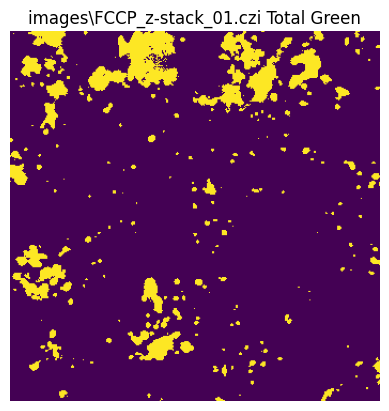

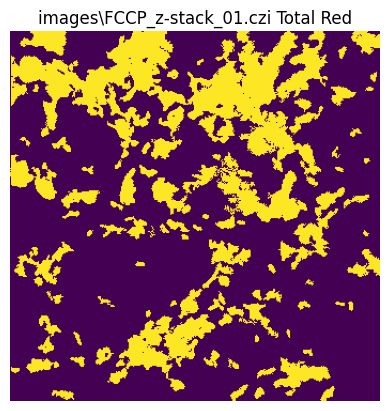

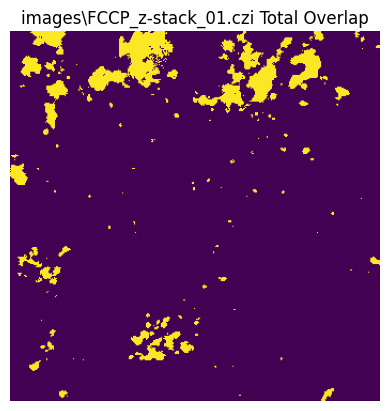

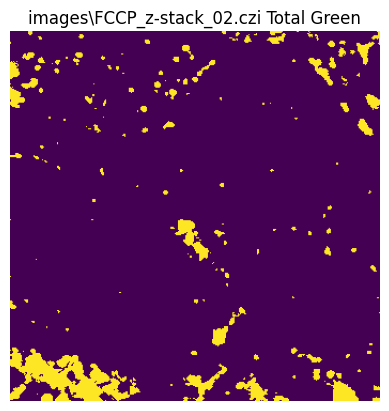

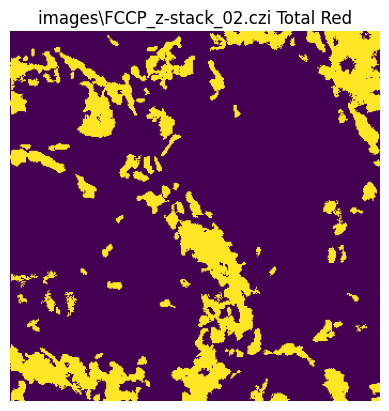

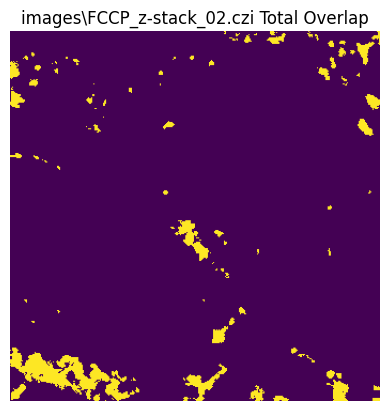

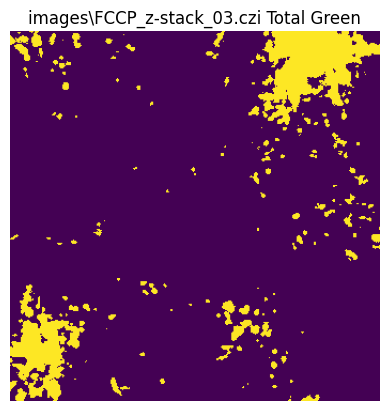

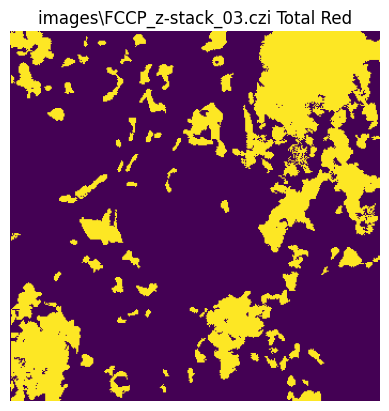

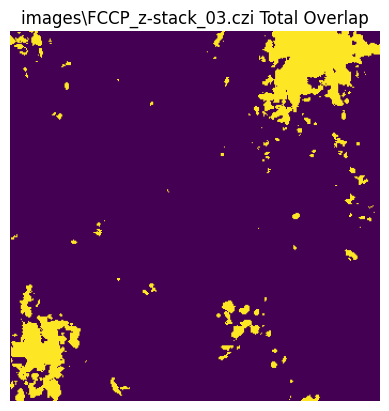

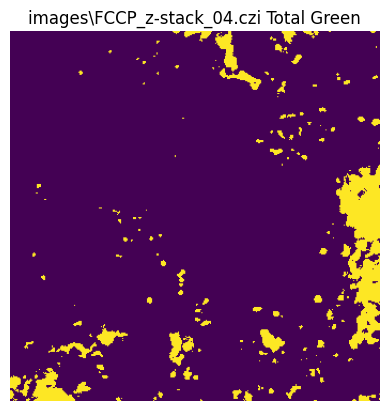

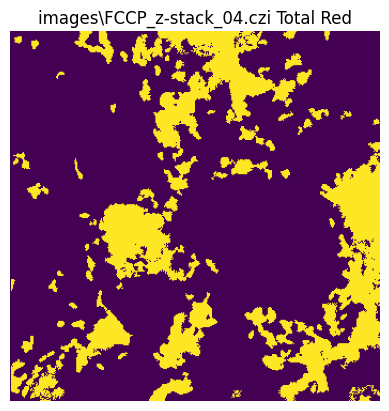

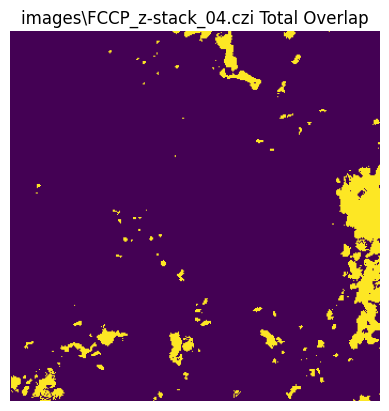

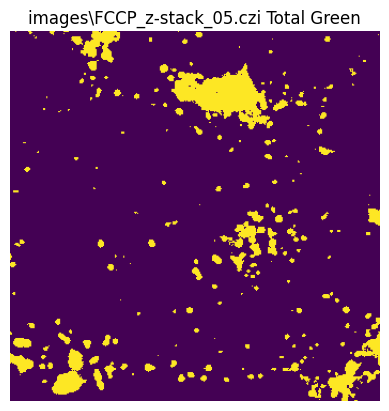

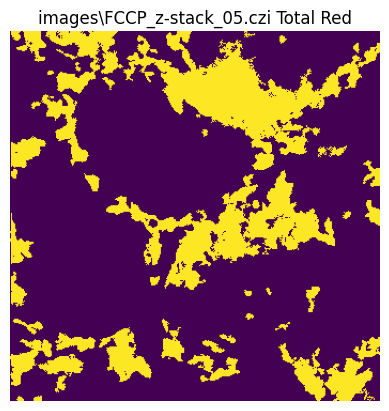

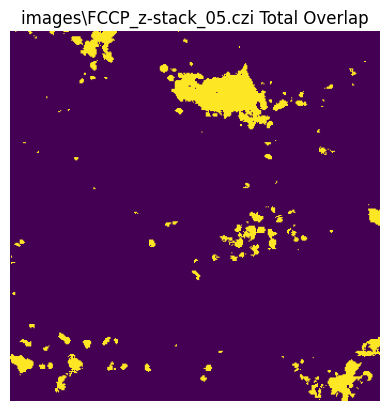

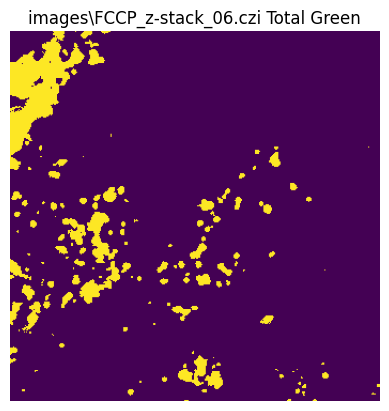

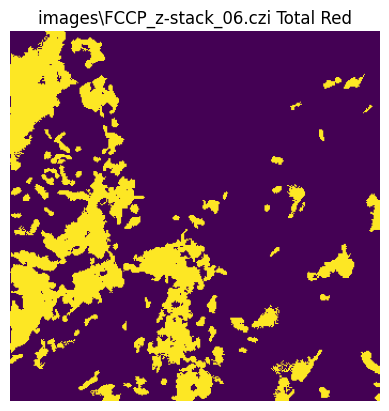

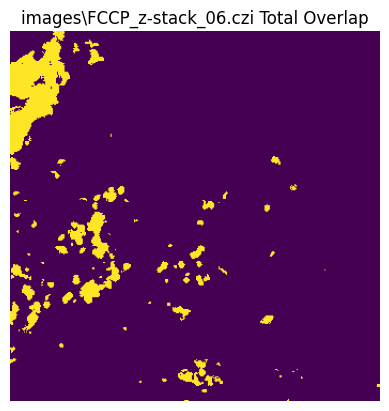

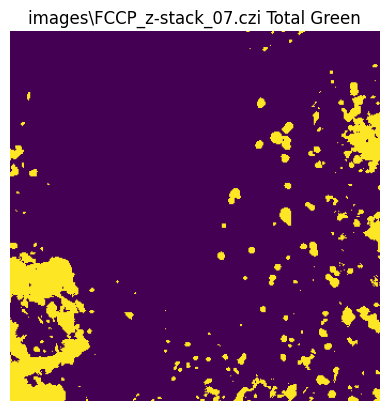

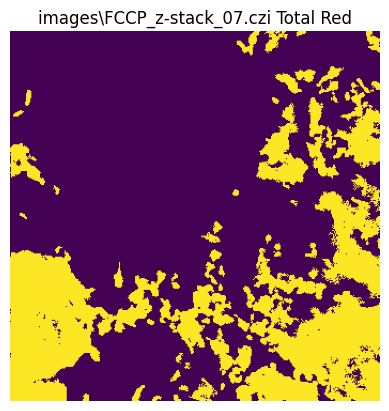

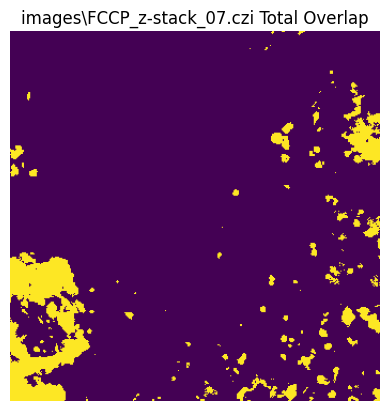

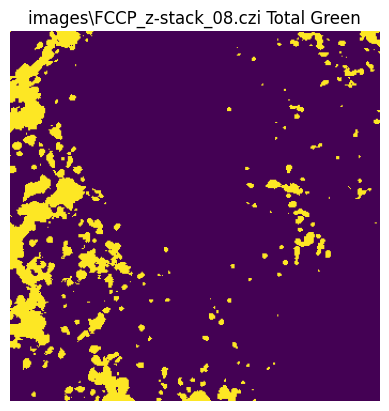

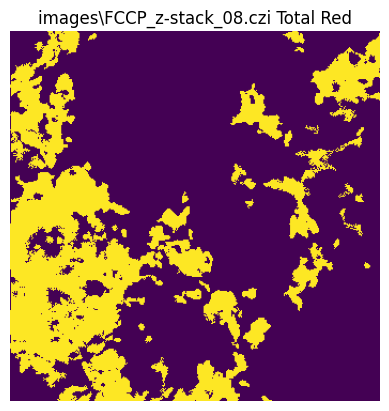

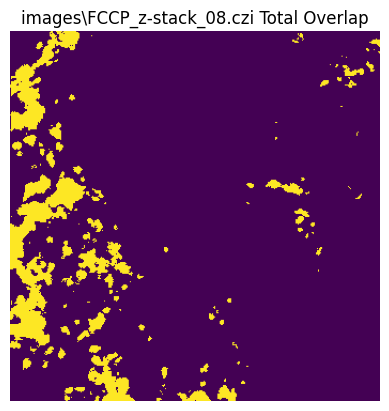

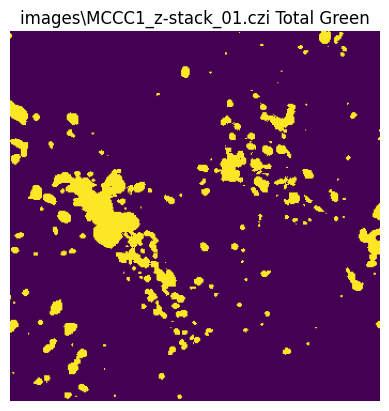

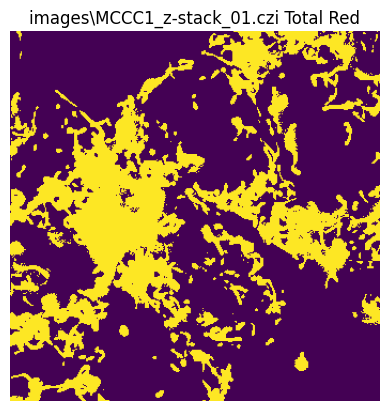

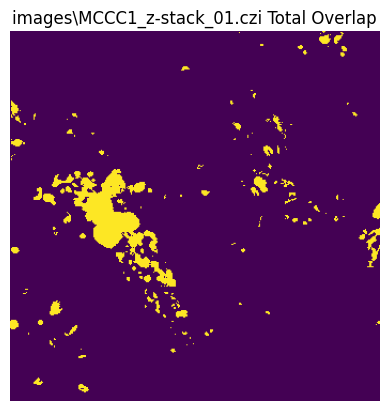

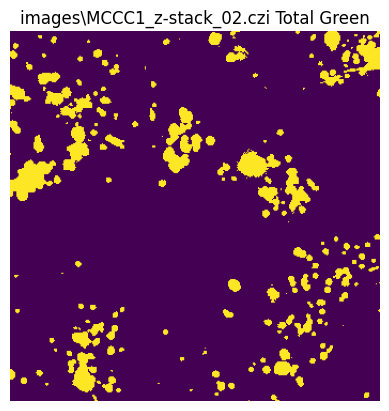

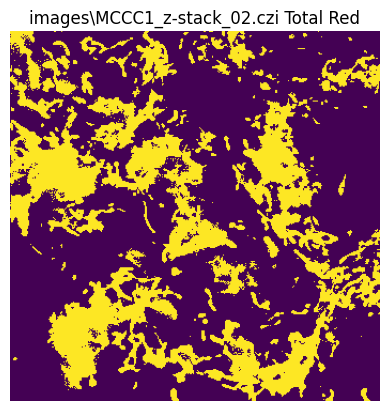

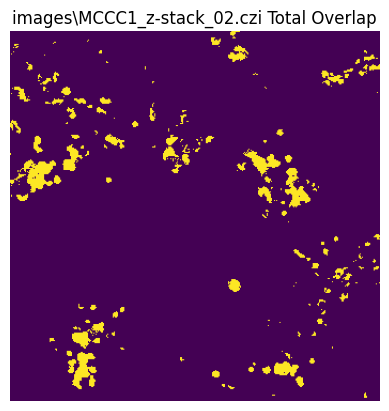

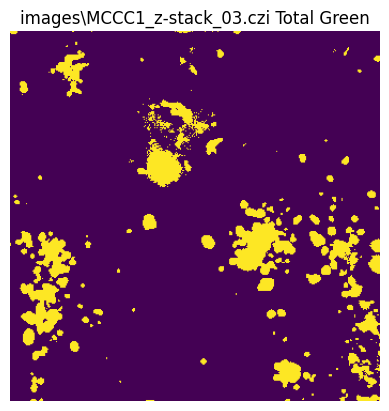

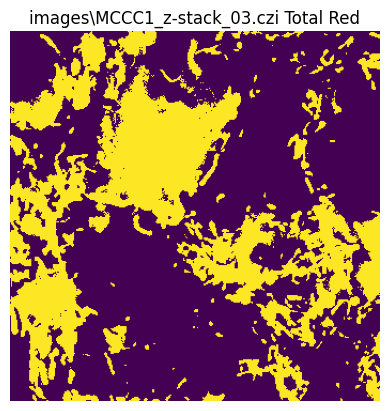

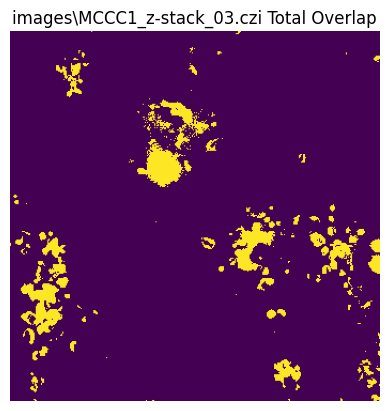

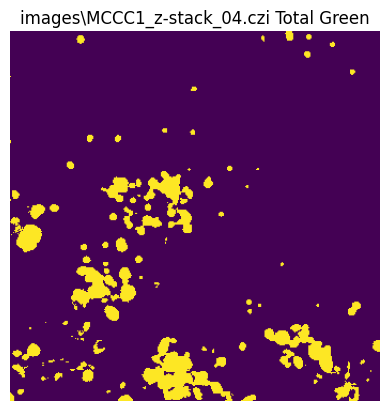

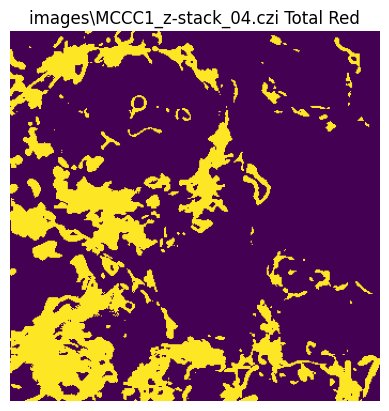

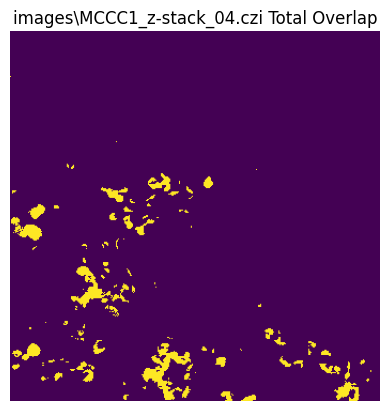

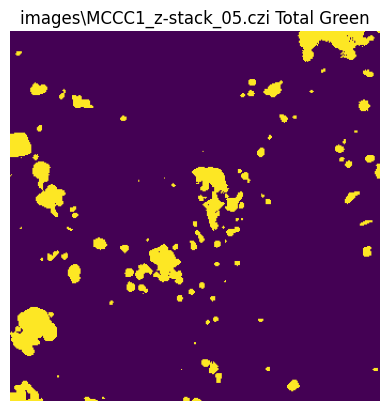

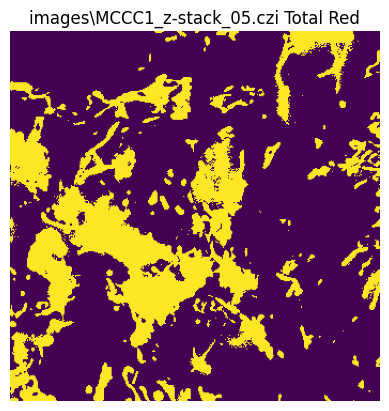

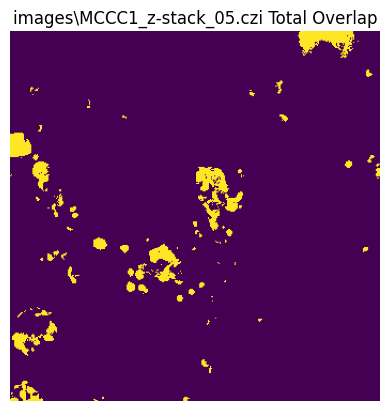

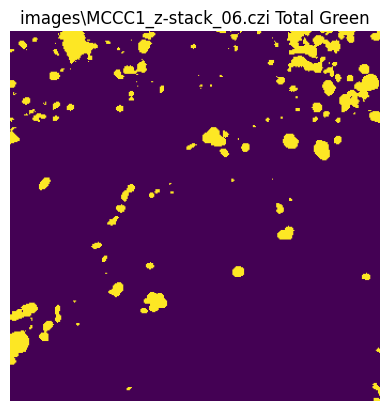

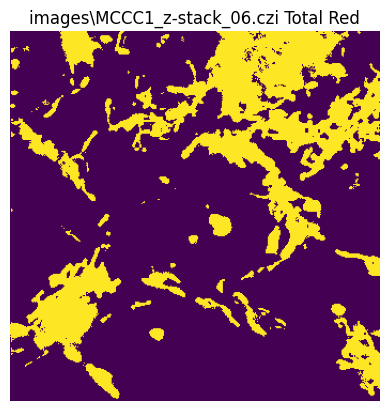

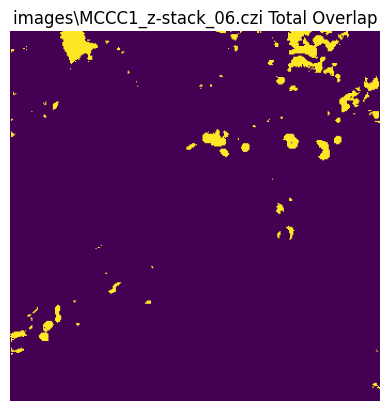

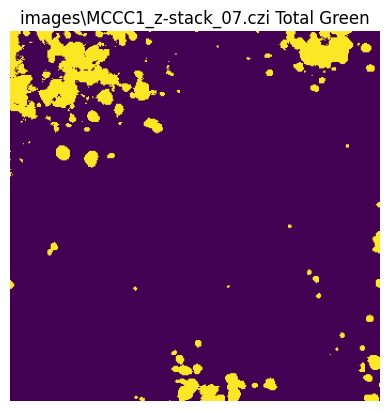

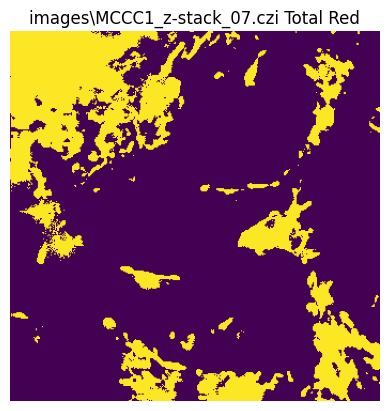

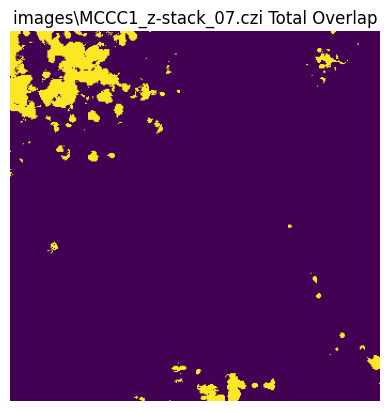

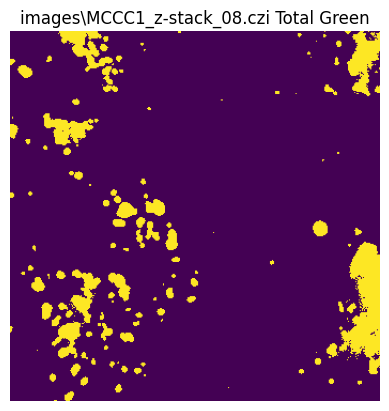

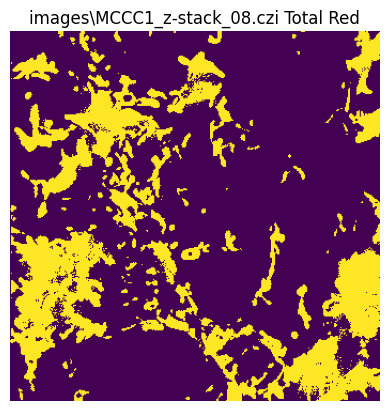

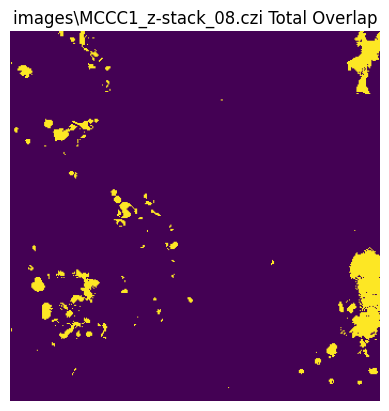

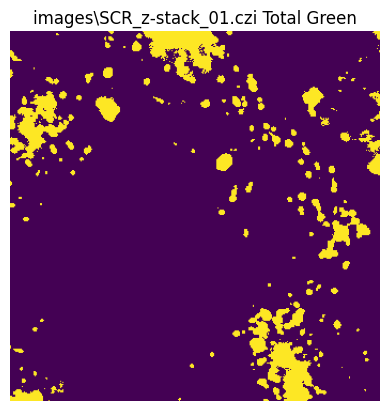

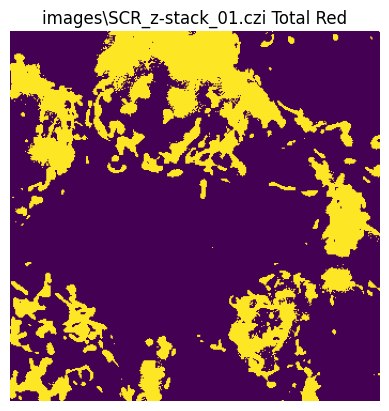

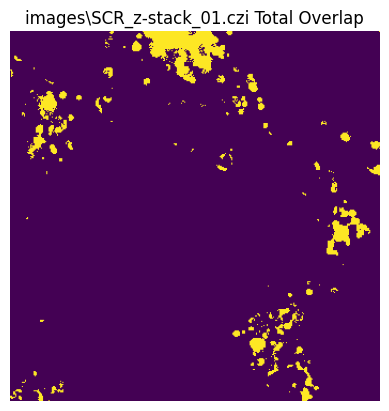

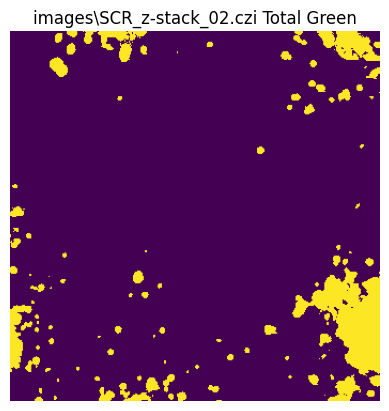

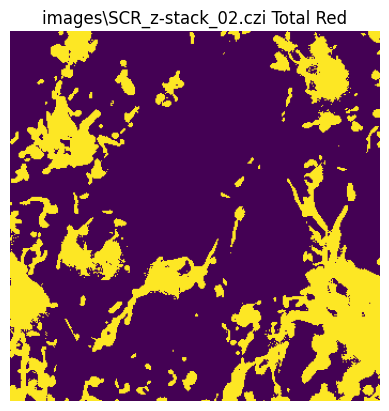

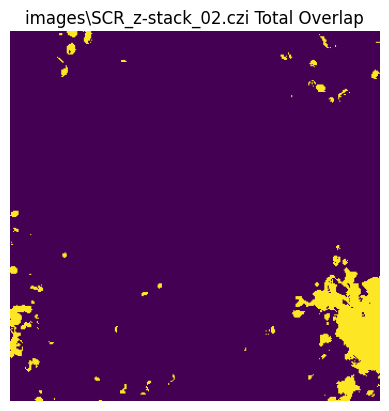

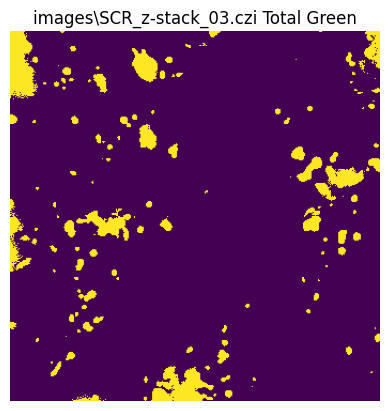

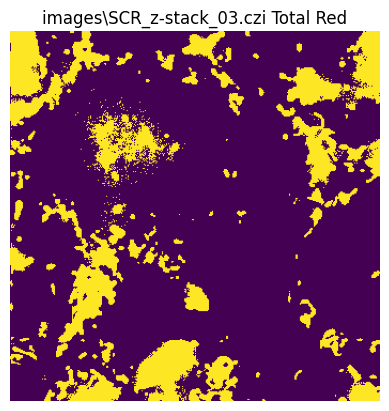

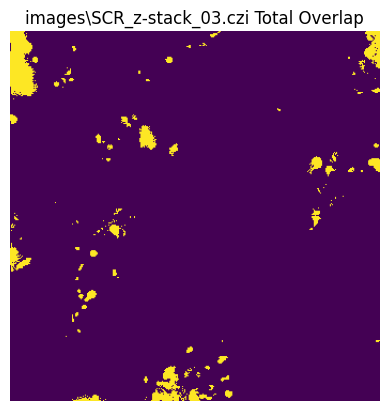

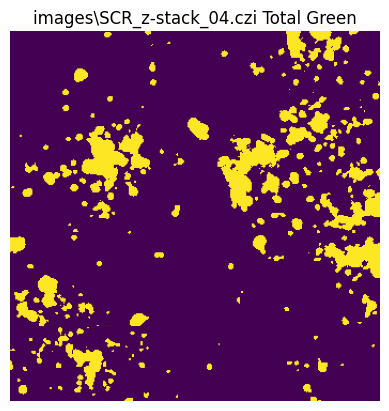

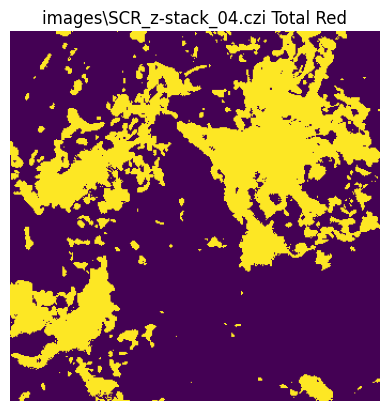

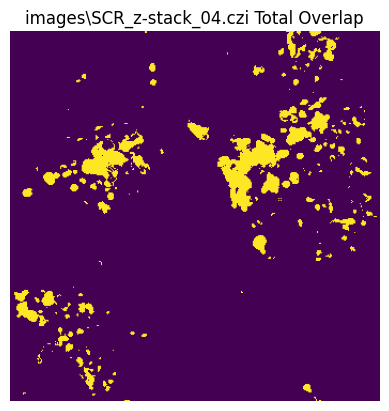

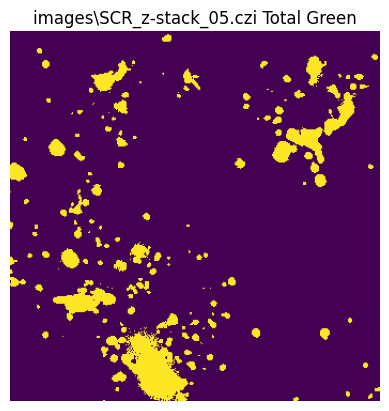

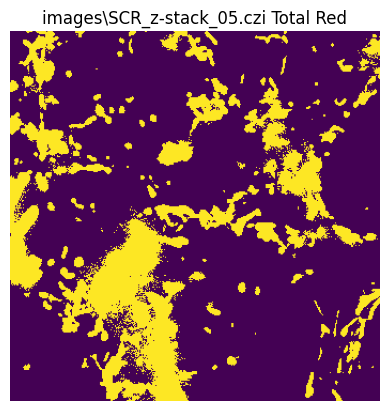

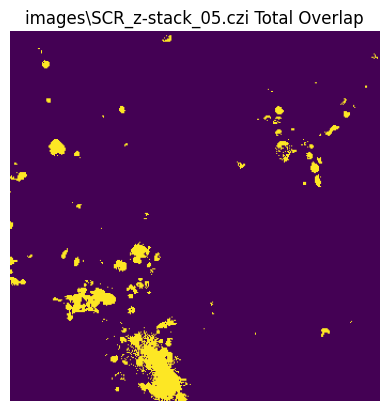

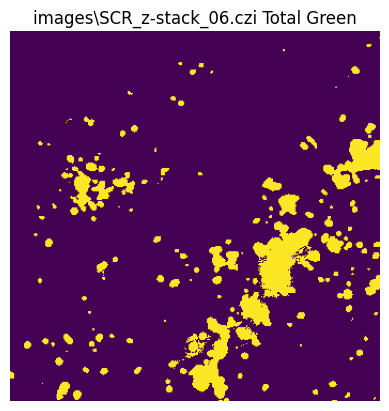

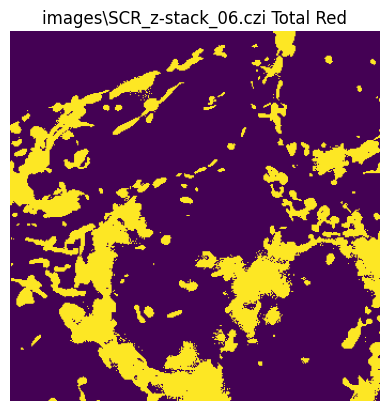

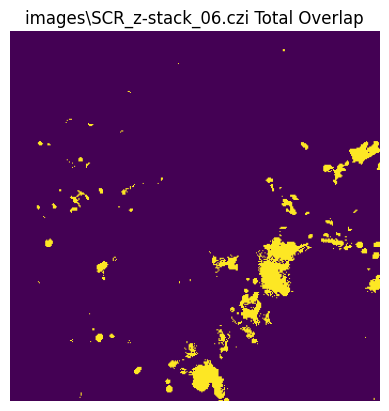

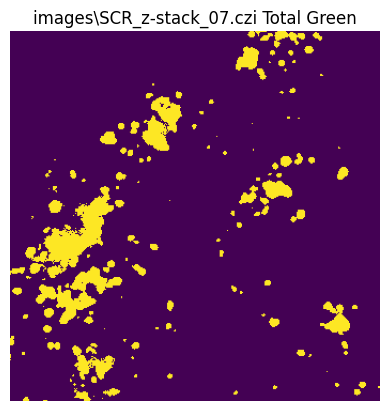

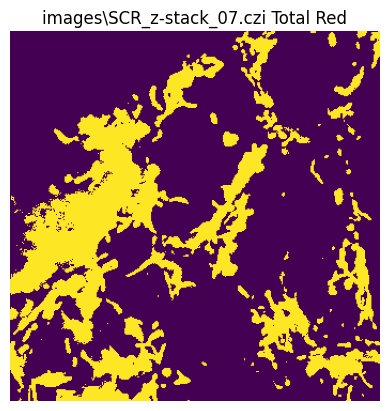

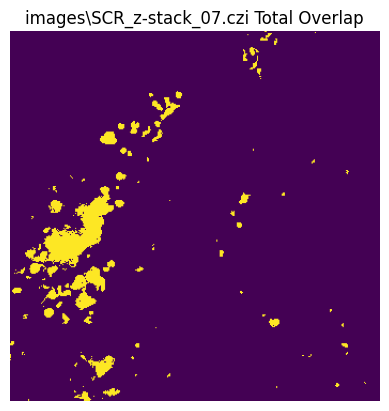

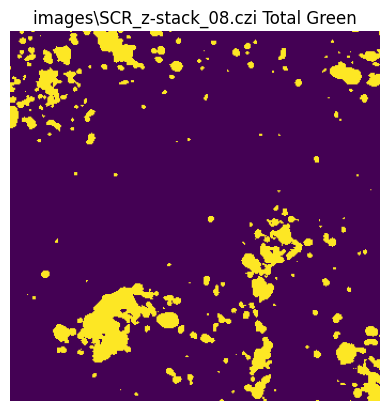

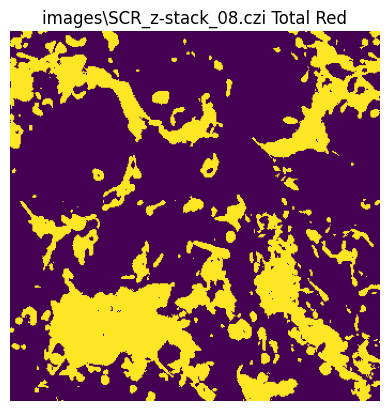

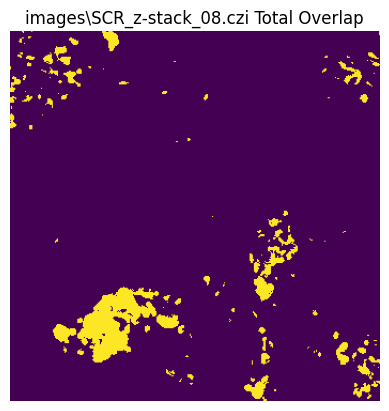

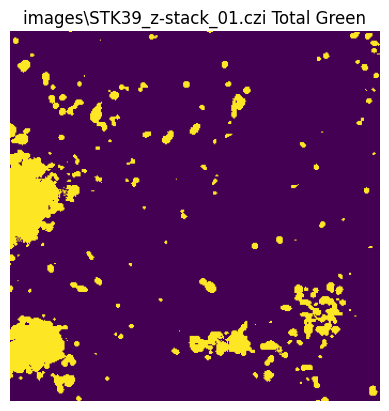

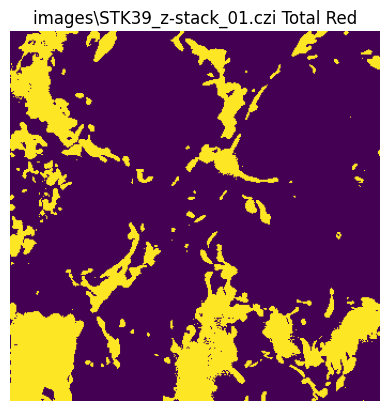

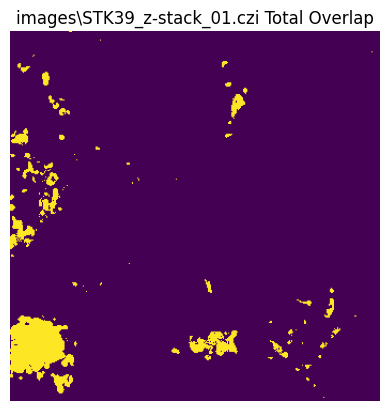

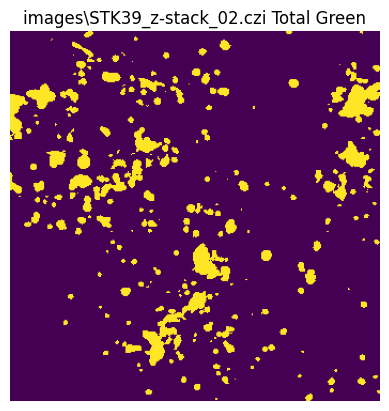

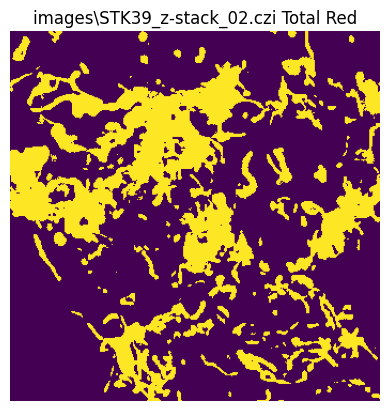

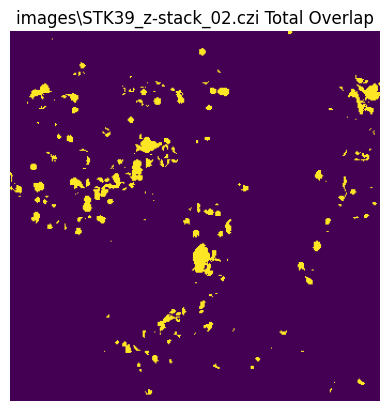

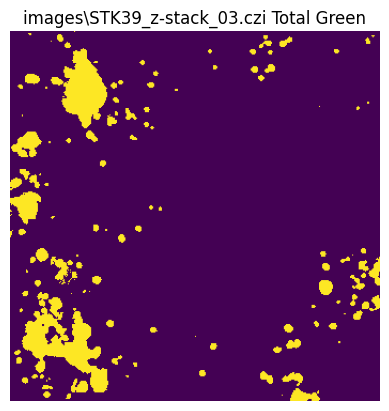

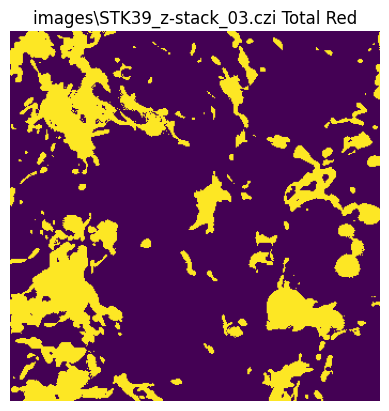

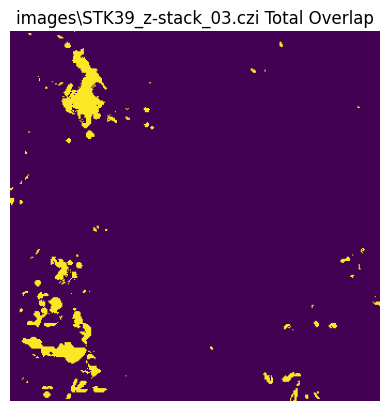

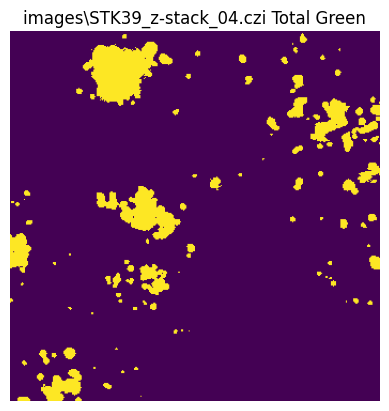

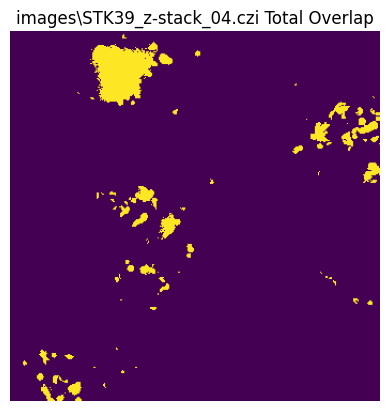

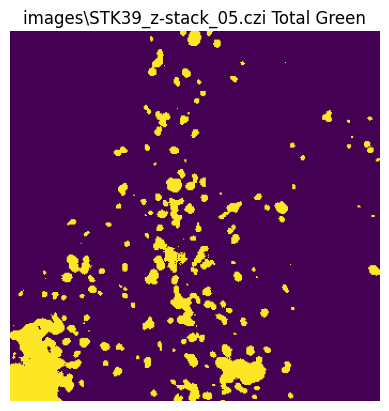

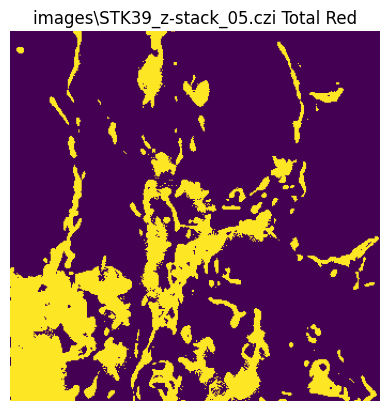

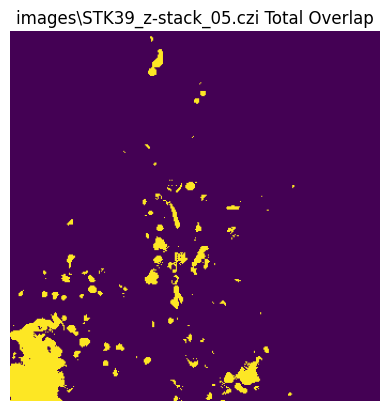

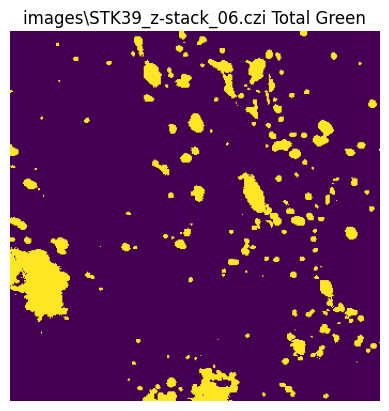

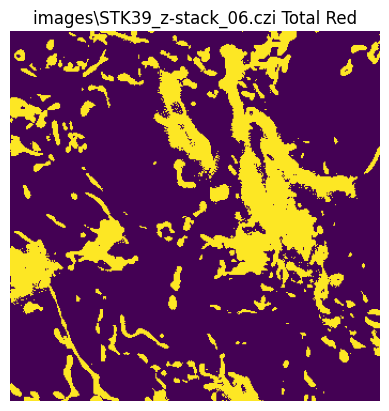

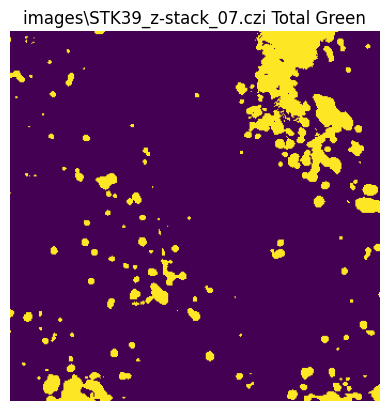

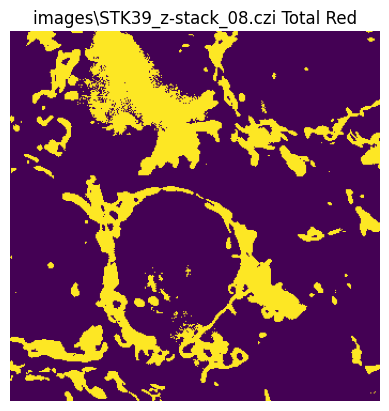

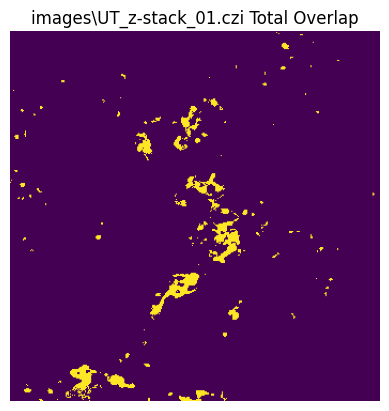

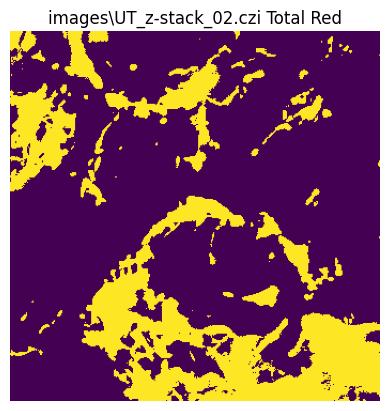

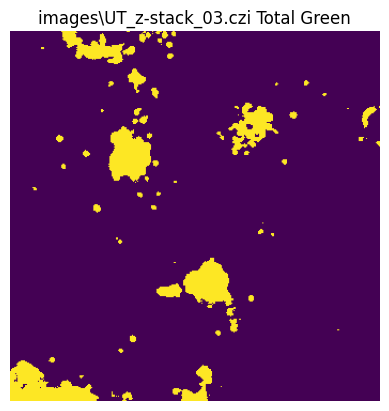

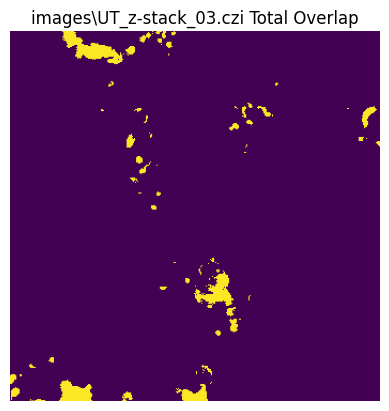

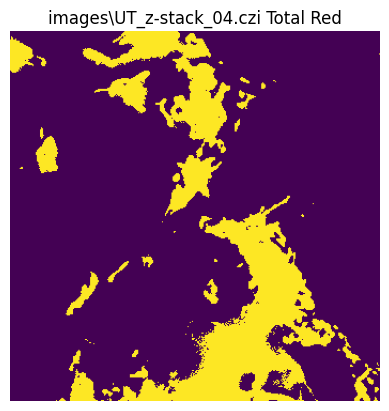

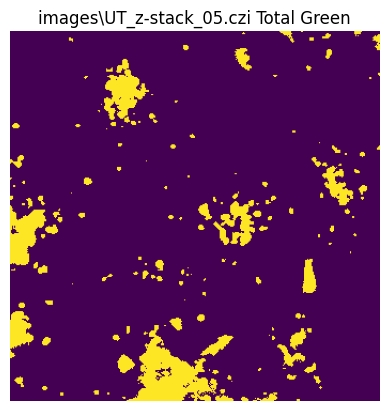

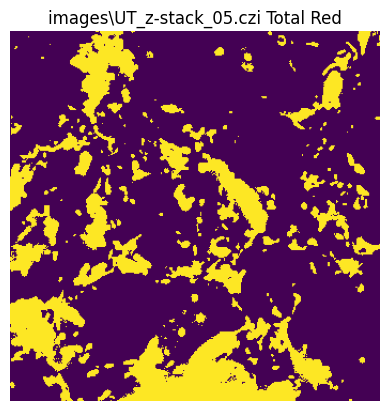

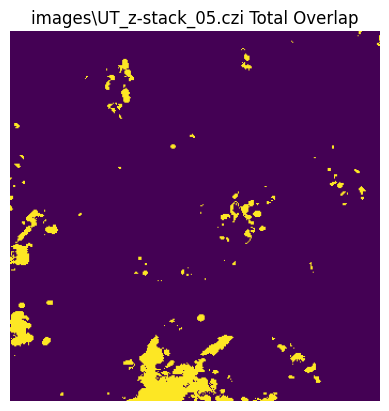

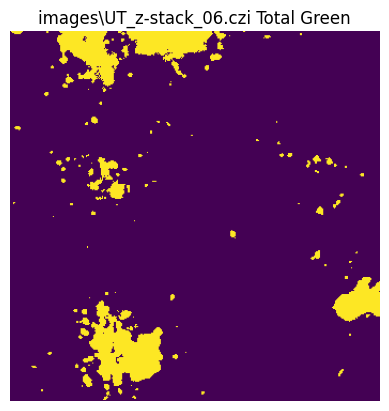

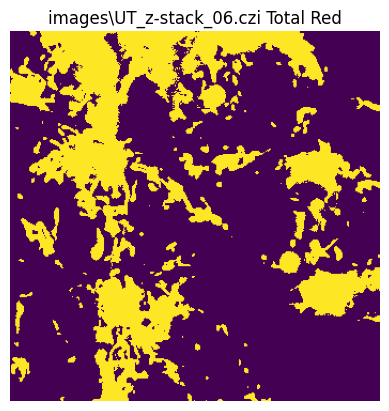

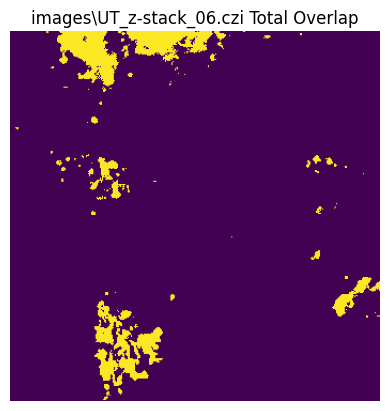

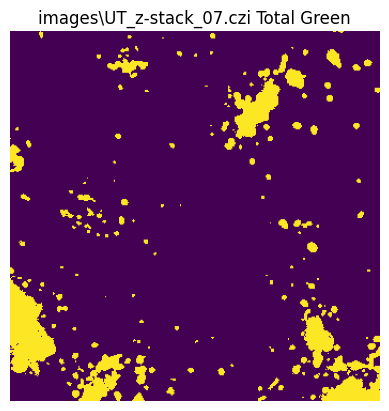

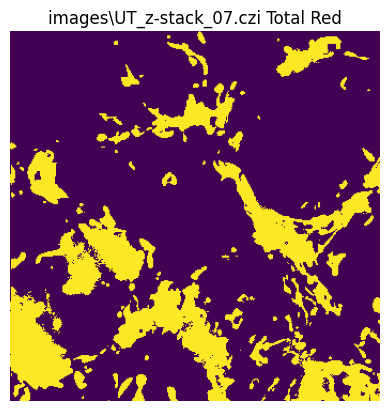

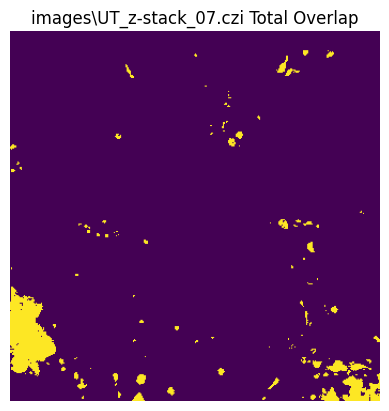

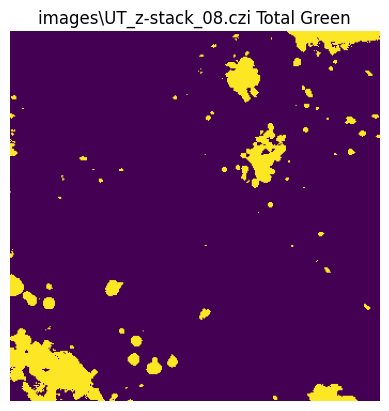

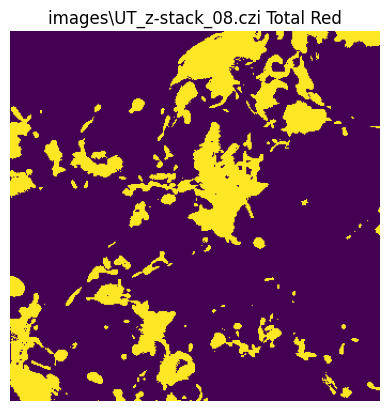

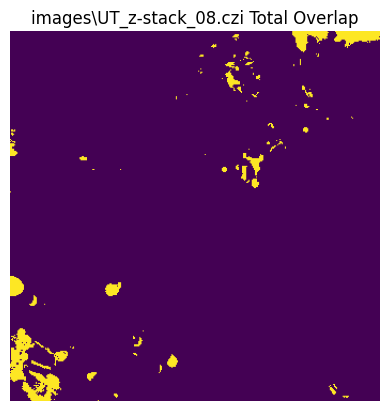

In [21]:
def main(image_folder):
    images_to_analyze = extract_image_paths(image_folder)
    output_dir = os.getcwd()

    df_MIP_summary_list = []
    df_z_stack_summary_list = []
    df_z_stack_total_summary_list = []
    for path in images_to_analyze:
        image = read_image(path)
        image_squeezed = np.squeeze(image) 
        height = image_squeezed.shape[1]  # get the height and width of the image
        width = image_squeezed.shape[2]

        green, red = extract_channels(image_squeezed) #extract green and red channels
        if (re.search(r'MIP', path)):
            df_MIP_summary = MIP_analysis(green, red, width, height, path)
            df_MIP_summary_list.append(df_MIP_summary)
        elif (re.search(r'(?i)z-stack(?!.*mip)', path)):
            df_z_stack_summary, df_z_stack_total_summary = z_stack(image_squeezed, path)
            df_z_stack_summary_list.append(df_z_stack_summary)
            df_z_stack_total_summary_list.append(df_z_stack_total_summary)
        else:
            #apply otsu thresholding on both
            contrast_adjusted_red_normalized = (red - red.min()) / (red.max() - red.min())
            threshold_value_mitochondria = np.mean(contrast_adjusted_red_normalized) + (np.std(contrast_adjusted_red_normalized) * 2) #1.75 works well

            constrast_adjusted_green_normalized = (green - green.min()) / (green.max() - green.min())
            threshold_value_green = np.mean(constrast_adjusted_green_normalized) + (np.std(constrast_adjusted_green_normalized) * 3.25) #1.75 works well
            otsu_threshold_red_value = threshold_otsu(red)
            otsu_threshold_green_value = threshold_otsu(green)
            #print("Otsu Threshold Red:", otsu_threshold_red_value, "Otsu Threshold Green:", otsu_threshold_green_value)

            if (otsu_threshold_red_value < 800):
                mitochondria_thresholded = red > otsu_threshold_red_value
                while (np.any(mitochondria_thresholded != False)):
                    otsu_threshold_red_value += .05
                    mitochondria_thresholded = red > otsu_threshold_red_value
            elif (threshold_value_green < 800):
                green_thresholded = green > otsu_threshold_green_value
                while (np.any(green_thresholded != False)):
                    otsu_threshold_green_value += .05
                    green_thresholded = green > otsu_threshold_green_value

                
            
            mitochondria_thresholded = red > otsu_threshold_red_value
            green_thresholded = green > otsu_threshold_green_value
            #display_image(mitochondria_thresholded, path, "Red channel")
            #display_image(green_thresholded, path, "Green channel")
            
            #print(f"{otsu_threshold_red_value} mitochondria threshold for {path}")
            #print(f"{otsu_threshold_green_value} green threshold for {path}")
            


    combined__MIP_summary_df = pd.concat(df_MIP_summary_list, ignore_index=True)
    output_MIP_summary_path = os.path.join(output_dir, 'MIP.xlsx')
    combined__MIP_summary_df.to_excel(output_MIP_summary_path, index=False)

    combined_z_stack_summary_df = pd.concat(df_z_stack_summary_list, ignore_index=True)
    output_z_stack_summary_path = os.path.join(output_dir, 'Z_Stack.xlsx')
    combined_z_stack_summary_df.to_excel(output_z_stack_summary_path, index=False)

    combined_z_stack_total_summary_df = pd.concat(df_z_stack_total_summary_list, ignore_index=True)
    output_z_stack_total_summary_path = os.path.join(output_dir, 'Z_Stack_Total.xlsx')
    combined_z_stack_total_summary_df.to_excel(output_z_stack_total_summary_path, index=False)



        
if __name__ == "__main__":
    image_folder = 'images'
    main(image_folder)